Time (CPU):  1.8076977729797363
Time (GPU):  0.5325784683227539
Speedup (time_cpu/time_gpu): 3.3942374326035143
Source Image:


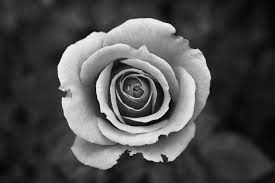

Interpolated Image GPU:


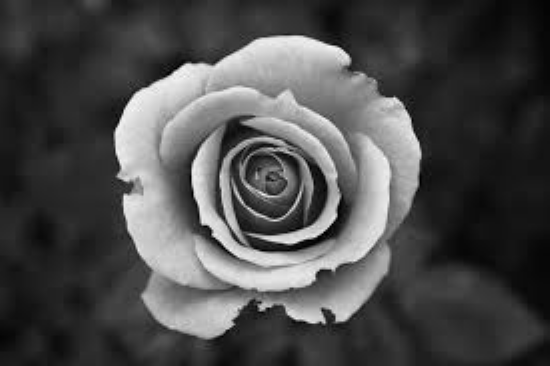

Interpolated Image CPU:


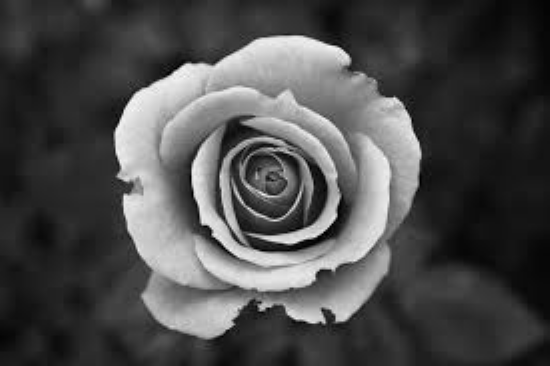

In [1]:
from numba import cuda
import numpy as np
from PIL import Image
import cv, cv2
import time

def binterp_cpu(src, dst_height, dst_width):
    dst = np.zeros((dst_height, dst_width), np.uint8)
    for y in range(dst_height):
        for x in range(dst_width):
            # Map the destination pixel to the source image
            src_x = x / 2
            src_y = y / 2

            # Find the four surrounding pixels in the source image
            x0 = int(src_x)
            x1 = min(x0 + 1, src.shape[1] - 1)
            y0 = int(src_y)
            y1 = min(y0 + 1, src.shape[0] - 1)

            # Interpolation weights
            wx = src_x - x0
            wy = src_y - y0

            # Perform bilinear interpolation
            top = (1 - wx) * src[y0, x0] + wx * src[y0, x1]
            bottom = (1 - wx) * src[y1, x0] + wx * src[y1, x1]
            dst[y, x] = (1 - wy) * top + wy * bottom
    return dst

@cuda.jit
def binterp_kernel(src, dst, scale_x, scale_y):
    # Get the thread's absolute position in the 2D grid
    x, y = cuda.grid(2)

    # Destination dimensions
    dst_height, dst_width = dst.shape

    if x < dst_width and y < dst_height:
        # Map the destination pixel to the source image
        src_x = x / scale_x
        src_y = y / scale_y

        # Find the four surrounding pixels in the source image
        x0 = int(src_x)
        x1 = min(x0 + 1, src.shape[1] - 1)
        y0 = int(src_y)
        y1 = min(y0 + 1, src.shape[0] - 1)

        # Interpolation weights
        wx = src_x - x0
        wy = src_y - y0

        # Perform bilinear interpolation
        top = (1 - wx) * src[y0, x0] + wx * src[y0, x1]
        bottom = (1 - wx) * src[y1, x0] + wx * src[y1, x1]
        dst[y, x] = (1 - wy) * top + wy * bottom

# Host function to use the kernel
def binterp_gpu(src, dst_height, dst_width):
    src_height, src_width = src.shape

    # Compute scaling factors
    scale_x = 2
    scale_y = 2

    # Allocate output array
    dst = np.zeros((dst_height, dst_width), np.uint8)

    # Copy data to device
    cuda_src = cuda.to_device(src)
    cuda_dst = cuda.to_device(dst)

    # Define grid and block dimensions
    threads_per_block = (16, 16)
    blocks_per_grid_x = (dst_width + threads_per_block[0] - 1) // threads_per_block[0]
    blocks_per_grid_y = (dst_height + threads_per_block[1] - 1) // threads_per_block[1]
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    # Launch the kernel
    binterp_kernel[blocks_per_grid, threads_per_block](cuda_src, cuda_dst, scale_x, scale_y)

    # Copy the result back to the host
    return cuda_dst.copy_to_host()

# Example source image (grayscale)
filename = 'rosebaw.jpg'
src_image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

# Target dimensions
src_height, src_width = src_image.shape

# Perform interpolation
start_cpu = time.time()
dst_image_cpu = binterp_cpu(src_image, 2*src_height, 2*src_width)
time_cpu = time.time() - start_cpu

start_gpu = time.time()
dst_image_gpu = binterp_gpu(src_image, 2*src_height, 2*src_width)
time_gpu = time.time() - start_gpu

#Time
print("Time (CPU): ", time_cpu)
print("Time (GPU): ", time_gpu)

#speedup
print("Speedup (time_cpu/time_gpu):", time_cpu/time_gpu)

#images
print("Source Image:")
img = Image.fromarray(src_image)
display(img)

print("Interpolated Image GPU:")
img = Image.fromarray(dst_image_gpu)
display(img)

print("Interpolated Image CPU:")
img = Image.fromarray(dst_image_cpu)
display(img)